In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [4]:
# Load data
data = pd.read_csv('../data/stocks_clean.csv', index_col='Date', parse_dates=True)

# Exploratory Data Analysis

## AAPL Adjusted Close Stock Price
Plotting the time series of AAPL's stock prices, we see that there seems to be an upward trend with notable fluctuations along the way, suggesting non-stationarity.

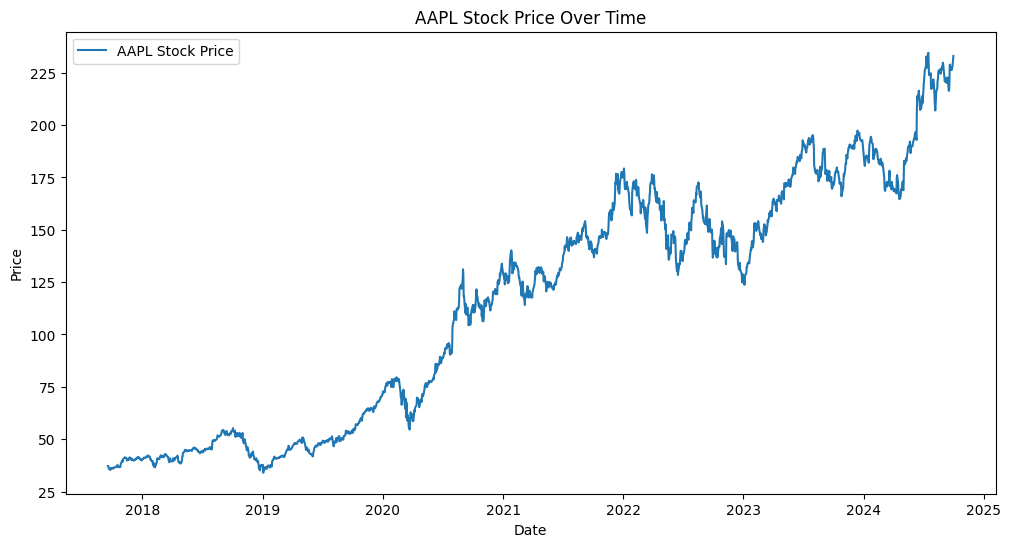

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data['aapl_adj_close'], label=f'AAPL Stock Price')
plt.title(f'AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Looking at the density distribution of the data over the same x axis scale, there is a much larger variance in `sp500_adj_close_lag` compared to the other distributions.

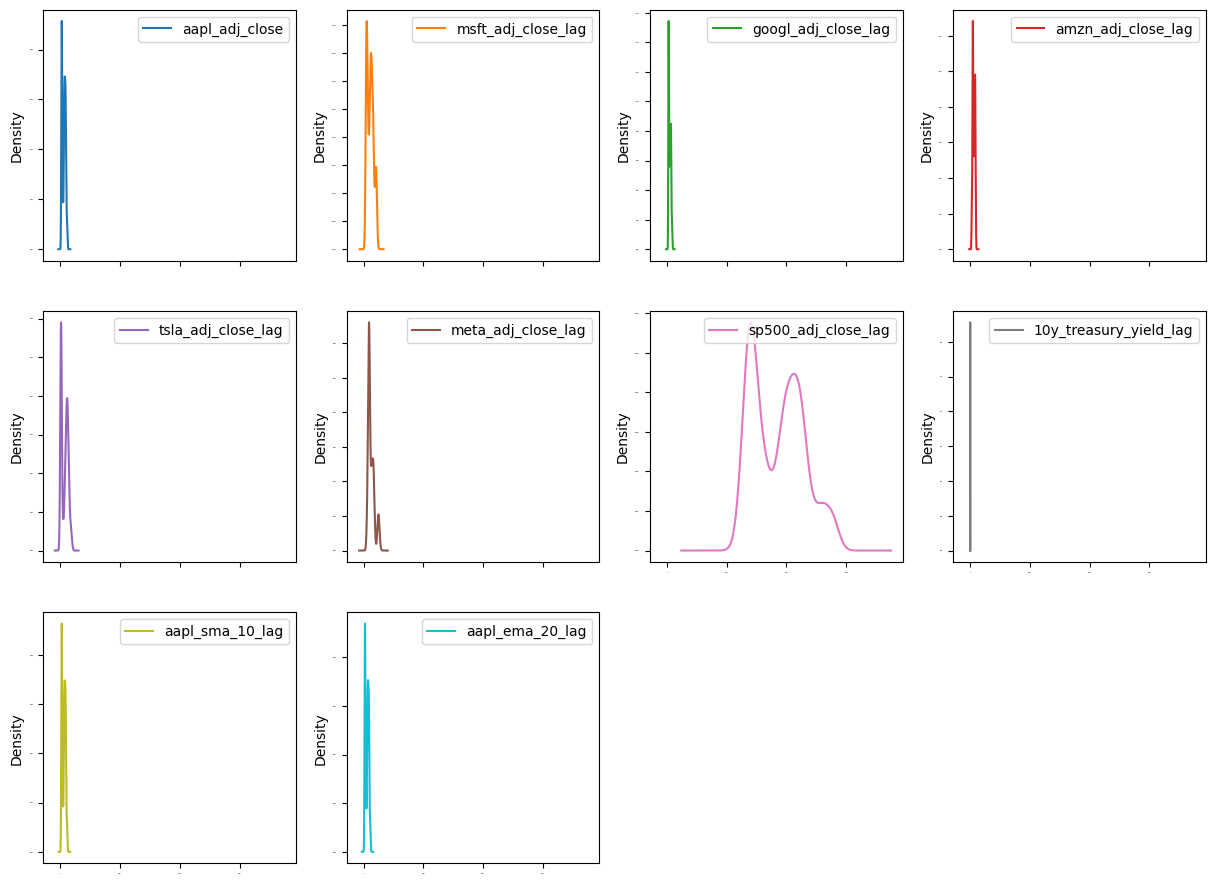

In [7]:
data.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

The correlation matrix shows that `aapl_adj_close` is highly correlated with the other features.

<Axes: title={'center': 'Correlation Matrix'}>

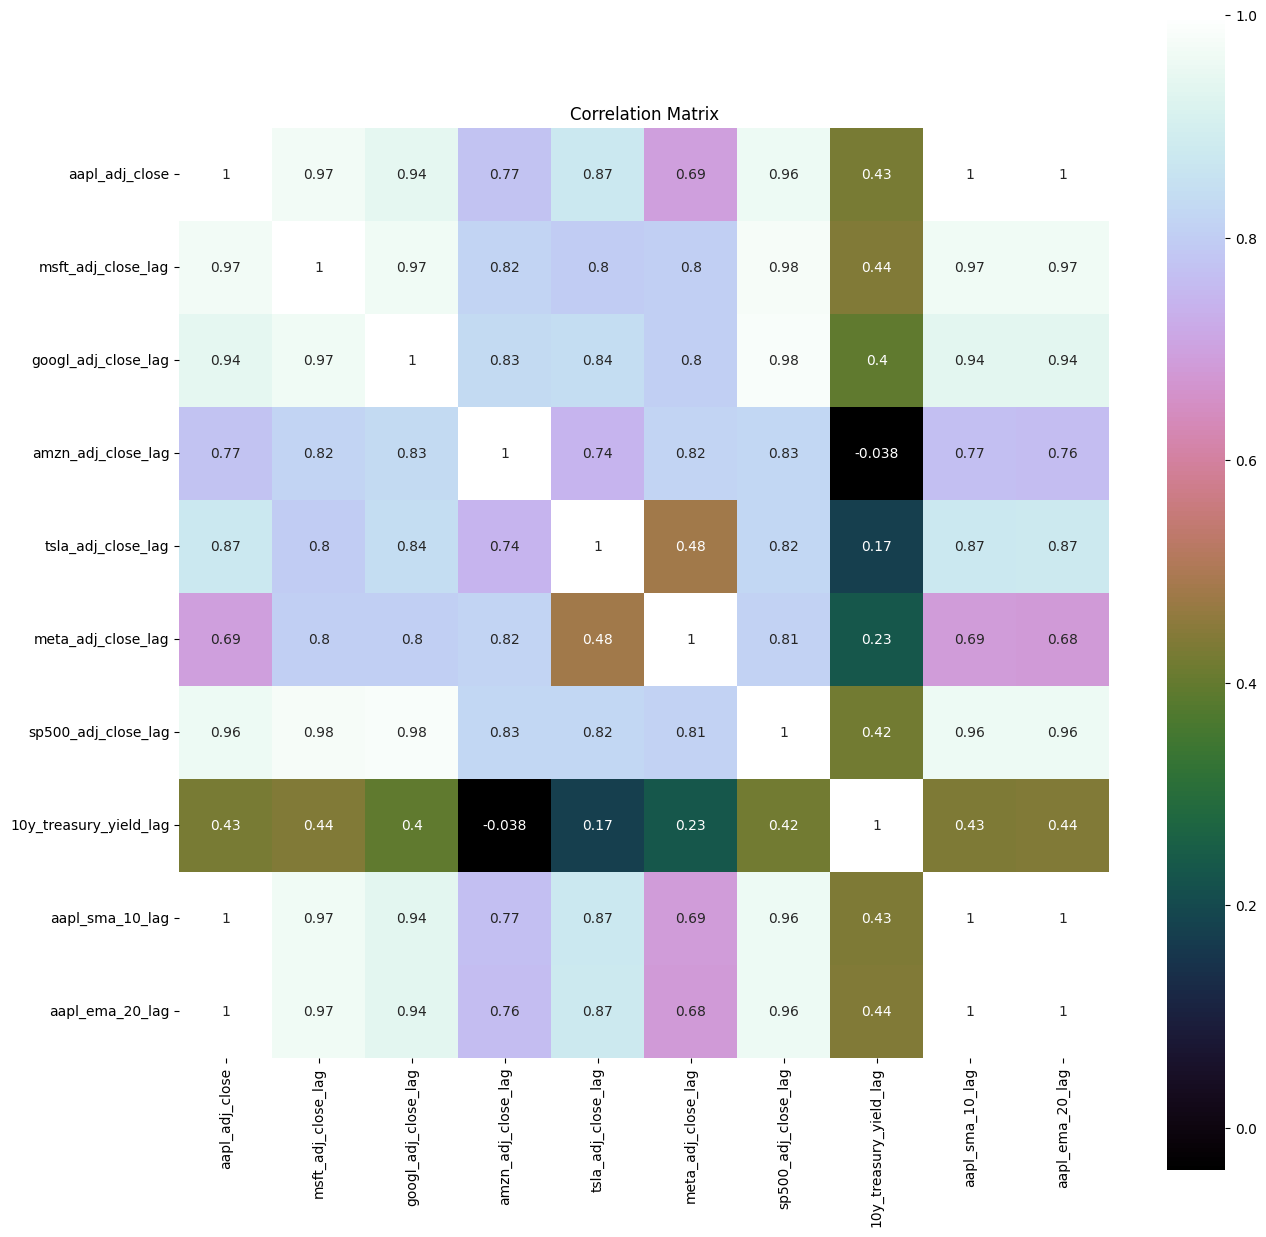

In [8]:
correlation = data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### ADF Test

The Augmented Dickey-Fuller (ADF) test checks for stationarity in the time series data. If the **p-value** is greater than 0.05, the data is non-stationary, and we need to apply differencing.

In this case, the data showed a non-stationary behavior, so we applied differencing to achieve stationarity.

In [17]:
# Perform ADF Test and print results
result = adfuller(data['aapl_adj_close'])
print(f'ADF Test for AAPL Stock Price:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')
print('---\n')
# Determine if the series is stationary
p_value = result[1]
if p_value < 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")
print('---\n')

ADF Test for AAPL Stock Price:
ADF Statistic: -0.08836021695954933
p-value: 0.9505856301965473
Critical Value (1%): -3.4340519866364954
Critical Value (5%): -2.8631752211631247
Critical Value (10%): -2.5676405414939345
---

The data is non-stationary (fail to reject the null hypothesis).
---



### ACF, PACF

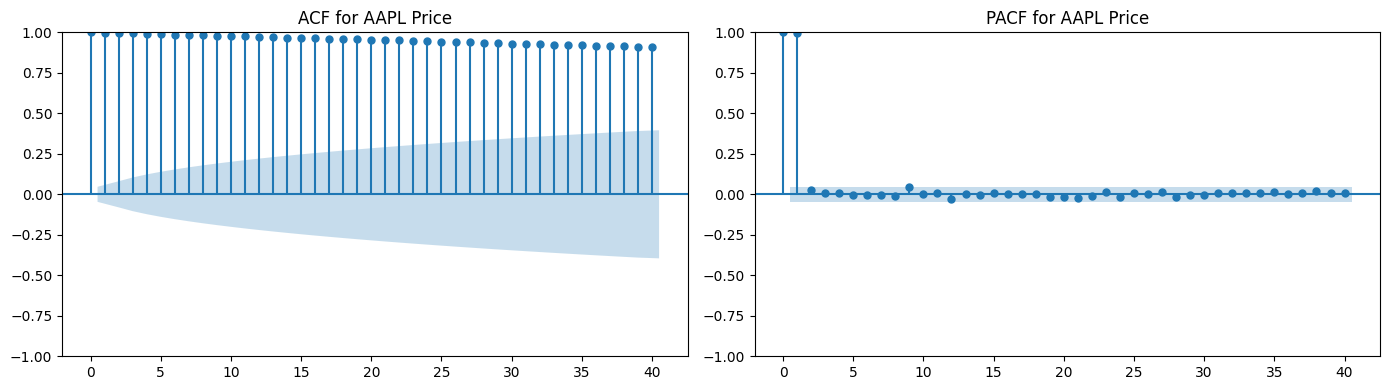

In [9]:
# Create subplots for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot ACF
plot_acf(data['aapl_adj_close'], lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title(f'ACF for AAPL Price')

# Plot PACF
plot_pacf(data['aapl_adj_close'], lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title(f'PACF for AAPL Price')

plt.tight_layout()
plt.show()


### Time Series Decomposition
Key Insights:
- Trend: Apple’s stock price has shown steady long-term growth, particularly accelerating after 2020.
- Seasonality: There are regular patterns of fluctuation, indicating that Apple’s stock price might have cyclical influences that recur annually or periodically.
- Residuals: There is significant noise in recent years, which might indicate an increase in volatility or the presence of short-term market shocks that affect the stock price.

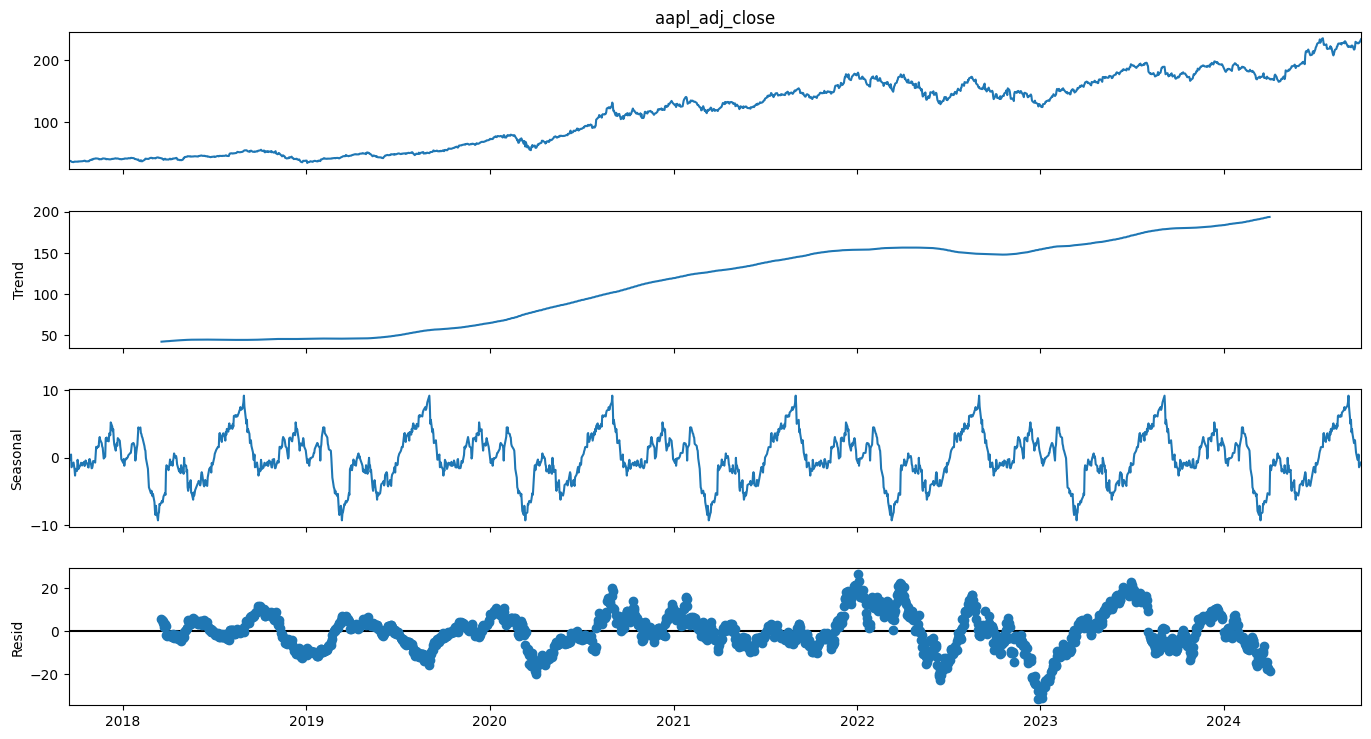

In [9]:
res = sm.tsa.seasonal_decompose(data['aapl_adj_close'], period=252)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## Differenced AAPL Adjusted Close Stock Price
The differenced series appears to be stationary, preparing the data for models like ARIMA. 

Around 2020, volatility significantly increases. This aligns with the COVID-19 pandemic and other economic disruptions during that time, where large spikes and drops in stock price can be observed.

After 2021, the fluctuations in price changes remain high, suggesting ongoing volatility in Apple's stock price, likely due to market uncertainty or macroeconomic conditions.

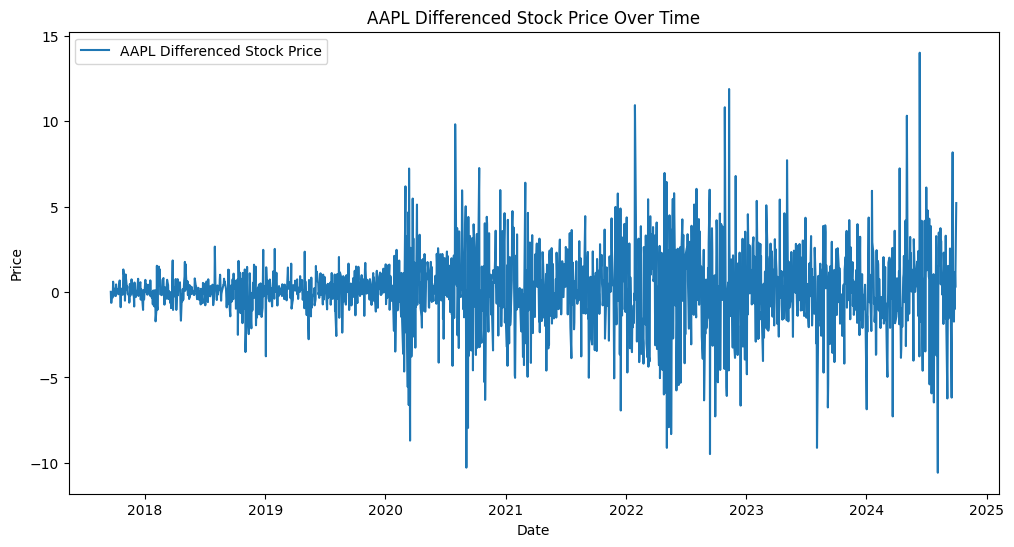

In [5]:
diff_data = data['aapl_adj_close'].diff().dropna()
plt.figure(figsize=(12, 6))
plt.plot(diff_data, label=f'AAPL Differenced Stock Price')
plt.title(f'AAPL Differenced Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### ADF Test

In [6]:
# Perform ADF Test and print results
result = adfuller(diff_data)
print(f'ADF Test for Differenced AAPL Stock Price:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')
print('---\n')
# Determine if the series is stationary
p_value = result[1]
if p_value < 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")
print('---\n')


ADF Test for Differenced AAPL Stock Price:
ADF Statistic: -42.56427958822336
p-value: 0.0
Critical Value (1%): -3.434054083572257
Critical Value (5%): -2.8631761468358614
Critical Value (10%): -2.567641034389652
---

The data is stationary (reject the null hypothesis).
---



### ACF, PACF

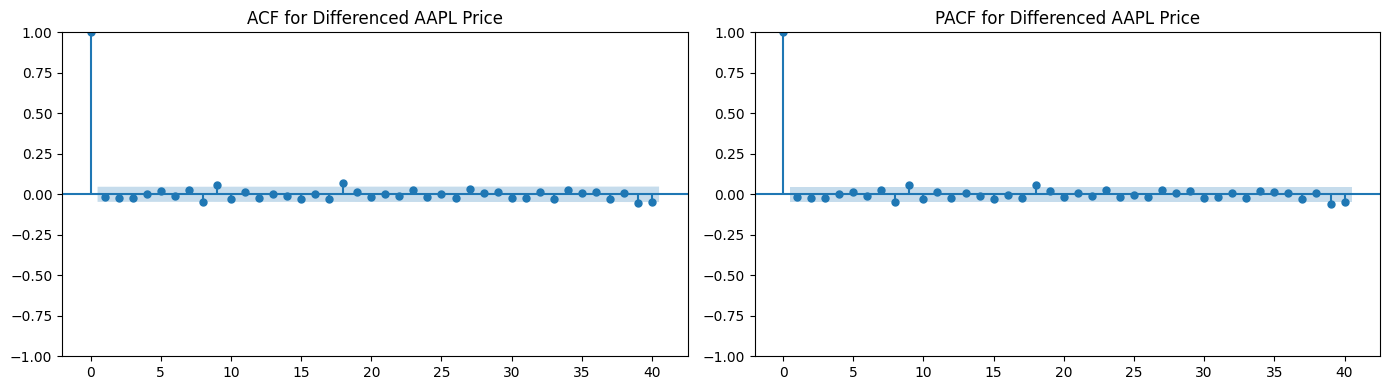

In [7]:
# Create subplots for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot ACF
plot_acf(diff_data, lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title(f'ACF for Differenced AAPL Price')

# Plot PACF
plot_pacf(diff_data, lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title(f'PACF for Differenced AAPL Price')

plt.tight_layout()
plt.show()

# Normalise data

In [6]:
y = data['aapl_adj_close']
X = data.drop(columns=['aapl_adj_close'])

# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the features (X)
X_scaled = scaler_X.fit_transform(X)

# Convert the scaled X back to a DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Fit and transform the target (y), needs to be reshaped as it's 1D
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled y back to a DataFrame to preserve column name
y_scaled = pd.DataFrame(y_scaled, columns=['aapl_adj_close'], index=y.index)


# Train, Test Split

In [7]:
train_size = 0.8
ntrain = round(len(y) * 0.8)
ntest = len(y) - ntrain
X_train, X_test = X[:ntrain], X[ntrain:]
y_train, y_test = y[:ntrain], y[ntrain:]
print(f"Train size: {ntrain}, Test size: {ntest}")

Train size: 1416, Test size: 354


## ARIMA Model

In [8]:
# Function to evaluate ARIMA model
def evaluate_arima_model(y_train, y_test, arima_order):
    # Fit the ARIMA model on the training set (target only)
    model = ARIMA(y_train, order=arima_order)
    model_fit = model.fit()
    
    # Forecasting the test set period
    forecast = model_fit.forecast(steps=len(y_test))
    
    # Calculate RMSE between actual test set and the forecast
    error = root_mean_squared_error(y_test, forecast)
    
    return error

In [9]:
# Grid search for ARIMA hyperparameters (p, d, q)
def grid_search_arima(y_train, y_test, p_values, d_values, q_values):
    best_score, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(y_train, y_test, order)
                    if rmse < best_score:
                        best_score, best_order = rmse, order
                    print(f'ARIMA{order} RMSE={rmse}')
                except:
                    continue
    print(f'Best ARIMA model: ARIMA{best_order} with MSE={best_score}')
    return best_order

In [10]:
# Define the range for p, d, and q 
p_values = range(0, 3)  # Try p = 0, 1, 2
d_values = range(0, 2)  # Try d = 0, 1 (first differencing)
q_values = range(0, 3)  # Try q = 0, 1, 2

In [11]:
# Perform grid search to find the best (p, d, q) values for ARIMA model
best_order = grid_search_arima(y_train, y_test, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=95.53482175729573
ARIMA(0, 0, 1) RMSE=95.47906560059636
ARIMA(0, 0, 2) RMSE=95.42571491778973
ARIMA(0, 1, 0) RMSE=30.127827660436136
ARIMA(0, 1, 1) RMSE=30.078752319577333
ARIMA(0, 1, 2) RMSE=30.029884833002047
ARIMA(1, 0, 0) RMSE=39.385041112179344
ARIMA(1, 0, 1) RMSE=38.32145067156756
ARIMA(1, 0, 2) RMSE=37.97958572352221
ARIMA(1, 1, 0) RMSE=30.086157597265508
ARIMA(1, 1, 1) RMSE=30.03307146229129
ARIMA(1, 1, 2) RMSE=30.020601176897383
ARIMA(2, 0, 0) RMSE=38.2777244544615
ARIMA(2, 0, 1) RMSE=35.65755559092359
ARIMA(2, 0, 2) RMSE=33.921472499859
ARIMA(2, 1, 0) RMSE=30.0402327073513
ARIMA(2, 1, 1) RMSE=30.01854213376933
ARIMA(2, 1, 2) RMSE=30.02645485483238
Best ARIMA model: ARIMA(2, 1, 1) with MSE=30.01854213376933


### ARIMA Model Selection
The ARIMA model was chosen based on the grid search over different values of p, d, and q. These parameters represent the following:

- **p**: Number of lag observations included (Auto-regressive part)
- **d**: Degree of differencing (to make the data stationary)
- **q**: Size of the moving average window

The grid search selected the best combination of parameters based on the lowest **AIC** (Akaike Information Criterion) or **MSE** (Mean Squared Error). Lower values of AIC/BIC indicate a better-fitting model.

In [12]:
# Fit the best ARIMA model on the full training data
model = ARIMA(y_train, order=best_order)
model_fit = model.fit()

In [13]:
# Print the summary of the best ARIMA model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         aapl_adj_close   No. Observations:                 1416
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3074.316
Date:                Fri, 25 Oct 2024   AIC                           6156.633
Time:                        00:50:34   BIC                           6177.652
Sample:                             0   HQIC                          6164.486
                               - 1416                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3030      0.491      0.617      0.537      -0.660       1.266
ar.L2         -0.0151      0.036     -0.418      0.676      -0.086       0.056
ma.L1         -0.3563      0.493     -0.723      0.4

### ARIMA Model Forecast vs. Actual Test Data
In this plot, we compare the ARIMA model's forecast against the actual test data. The model was trained on 80% of the dataset and used to forecast the remaining 20% (test set).

The red line represents the model’s forecast, while the blue line represents the actual test data. The closer these lines are, the more accurate the model is.

In [14]:
# Forecast the test set period
forecast = model_fit.forecast(steps=len(y_test))

#### ARIMA Model Performance Analysis
Visual Analysis: From the forecast plot, we can observe that the predicted values (red line) deviate significantly from the actual stock prices (orange line) in several areas. This indicates that the ARIMA model struggled to capture some of the underlying trends and volatility in the data. The stock prices exhibited complex patterns, including sharp rises and falls, which the ARIMA model could not fully accommodate.

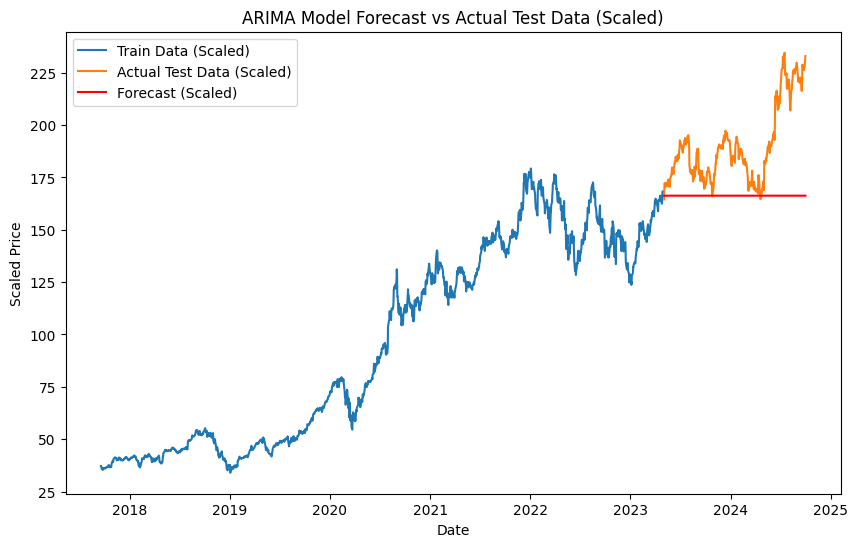

In [15]:
# Plot the forecast against the actual test data
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train Data (Scaled)')
plt.plot(y_test.index, y_test, label='Actual Test Data (Scaled)')
plt.plot(y_test.index, forecast, label='Forecast (Scaled)', color='red')
plt.title('ARIMA Model Forecast vs Actual Test Data (Scaled)')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

Quantitative Analysis: The performance of the ARIMA model was further evaluated using the following error metrics:

In [17]:
# Calculate the error metrics
rmse = root_mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 30.01854213376933
Mean Absolute Error (MAE): 23.72777158570204


Interpretation:

RMSE and MAE in the range of 12-16% of the stock price indicates that the ARIMA model captures some of the general trends but may not be fully effective in predicting short-term fluctuations or more volatile movements in the stock prices.
For financial time series, where even small changes in stock prices can have significant impacts, a 12-16% error might be considered relatively large.
Room for Improvement: While the model is reasonable, you may want to explore more advanced models, such as SARIMA, ARIMAX, or machine learning models like XGBoost, Random Forests, or LSTMs, especially for stock price forecasting, which often involves more complex patterns and external factors.

In [18]:
# Calculate average stock price in y_test for comparison
average_price = np.mean(y_test)

# Calculate percentage of RMSE and MAE relative to the average price
rmse_percentage = (rmse / average_price) * 100
mae_percentage = (mae / average_price) * 100

print(f'Average Stock Price in Test Set: {average_price}')
print(f'RMSE as percentage of average price: {rmse_percentage}%')
print(f'MAE as percentage of average price: {mae_percentage}%')

Average Stock Price in Test Set: 189.98330093642411
RMSE as percentage of average price: 15.800621415571001%
MAE as percentage of average price: 12.48939852542213%
